# A Multivariate Time Series Guide to Forecasting and Modeling

* Ref: [https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/](https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/)
* Data: https://archive.ics.uci.edu/ml/datasets/Air+Quality


* Time series 分成兩種:
  * Univariate time series: 只有一個 time-dependent variable
  * Multivariate time series: 不只一個 time-dependent variable
    * variable 和自己過去的值有關，也和其他變數過去的值有關
* Vector Auto Regression (VAR):
  * 每一個變數，是自己過去的數值和其他變數過去的數值的線性組合
  * VAR 可以利用變數之間的關聯性，來提供更好的預測結果
  * 如果有 k 個 time-dependemt 的變數，然後用 $p$ lags 來做模型:
    * 矩陣表示式: $\begin{bmatrix} y_{1}(t)\\ y_{2}(t) \\ \vdots \\ y_{k}(t) \end{bmatrix} = \begin{bmatrix} a_{1}\\ a_{2} \\ \vdots \\ a_{k} \end{bmatrix} + \begin{bmatrix} W^{1}_{11} & W^{1}_{12} & \cdots & W^{1}_{1k}\\ W^{1}_{21} & W^{1}_{22} & \cdots & W^{1}_{2k}& \\ \vdots & &\ddots \\ W^{1}_{k1} & W^{1}_{k2} & \cdots & W^{1}_{kk} \end{bmatrix} \begin{bmatrix} y_{1}(t-1)\\ y_{2}(t-1) \\ \vdots \\ y_{k}(t-1) \end{bmatrix} + \cdots + \begin{bmatrix} W^{p}_{11} & W^{p}_{12} & \cdots & W^{p}_{1k}\\ W^{p}_{21} & W^{p}_{22} & \cdots & W^{p}_{2k}& \\ \vdots & &\ddots \\ W^{p}_{k1} & W^{p}_{k2} & \cdots & W^{p}_{kk} \end{bmatrix} \begin{bmatrix} y_{1}(t-p)\\ y_{2}(t-p) \\ \vdots \\ y_{k}(t-p) \end{bmatrix} + \begin{bmatrix} e_{1} \\ e_{2} \\ \cdots \\ e_{k} \end{bmatrix}$
    * 向量表示式: $\mathbf{y}(t) = \mathbf{a} + \sum_{i=1}^{p} \mathbf{W}^{i} \cdot \mathbf{y}(t-i) + \mathbf{e}$
    * $\mathbf{a}$: 常數，$k \times 1$ 的向量
    * $\mathbf{W}^{i}$: 係數，$k \times k$ 的向量
    * $\mathbf{y}(t-i)$: 第 i 個 lag 形成的向量
    * $\mathbf{e}$: 誤差，$k \times 1$ 的向量
      * 誤差項彼此之間有關連性，並呈現 $N(0, \Sigma)$ 分佈
      * $E[e(t)] = 0$: 期望值必須要是 0
      * $E[e_{i}, e_{j}]$ 是 $k \times k$ 的向量
        * $E[e_{t}, e'_{t}] = \Sigma$，就是說對角線元素是 $\Sigma$ (可以不是 0)
        * $E[e_{t}, e_{t'}] = 0$，但是非對角線元素必須是 0

* 用 Johansen’s test 來檢查 stationarity

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display

## 1. Load data

In [28]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [29]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/AirQualityUCI.csv',
                 sep=';')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


### 1.1 Data preprocessing
* 注意 `Date` 和 `Time` 是兩個欄位，且 `Time` 的格式不是我要的，所以要轉換成只有一個欄位且是 `datetime64` 的型態，並且設為 index
  * 在 `parse_dates= list of lists` 會把所有指定的欄位合併成一個，但仍然維持 `str` 的型態
    * 要自己轉成 `datetime64` 的型態
* `CO(GT)`, `C6H6(GT)`, `T`, `RH`, `AH` 欄位的格式不對，要把 , 改成 . 然後把數值的型態改成 `float`
* 多了兩個欄位 `Unnamed: 15` 和	`Unnamed: 16` 要刪掉

In [31]:
# 用這個方式的話，不知道為什麼 `Date_Time` 欄位的 row 數目會變多，所以換別的方法來處理
# df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/data/AirQualityUCI.csv',
#                  sep=';',
#                  parse_dates=[['Date', 'Time']])

df['Date_Time'] = df.apply(lambda row: str(row['Date']) + ' ' + str(row['Time']), axis=1)
df.drop(['Date', 'Time'], axis=1, inplace=True)
# df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%d/%m/%Y %H.%M.%S')

# 把型態不對的欄位改掉
for col in ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']:
    df[col] = df[col].str.replace(',', '.')
    df[col] = df[col].astype('float')

# 刪掉多餘的欄位
df.drop(['Unnamed: 15',	'Unnamed: 16'], axis=1, inplace=True)

df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Date_Time
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,10/03/2004 18.00.00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,10/03/2004 19.00.00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,10/03/2004 20.00.00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,10/03/2004 21.00.00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,10/03/2004 22.00.00


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
 13  Date_Time      9471 non-null   object 
dtypes: float64(13), object(1)
memory usage: 1.0+ MB


* 不知道為什麼 `Date_Time` 的 row 變多了，應該是 9357 但這邊卻是 9471，要檢查一下

In [33]:
df.iloc[9355: 9365]

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Date_Time
9355,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,04/04/2005 13.00.00
9356,2.2,1071.0,-200.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028,04/04/2005 14.00.00
9357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan nan
9358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan nan
9359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan nan
9360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan nan
9361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan nan
9362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan nan
9363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan nan
9364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan nan


In [34]:
df_test = df.iloc[9357:].drop('Date_Time', axis=1)
for col in df_test.columns:
  display(df_test[df_test[col].notnull()])

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH


* 因為後面的 row 都是空的，所以直接刪掉

In [35]:
df = df.iloc[:9357]
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Date_Time
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,10/03/2004 18.00.00
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,10/03/2004 19.00.00
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,10/03/2004 20.00.00
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,10/03/2004 21.00.00
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,10/03/2004 22.00.00


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
 13  Date_Time      9357 non-null   object 
dtypes: float64(13), object(1)
memory usage: 1023.5+ KB


In [37]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], format='%d/%m/%Y %H.%M.%S') # format 用來指明原本輸入的 datetime 的格式是怎樣的，這樣 to_datetime() 才知道該怎麼修改
df.set_index('Date_Time', inplace=True)
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
dtypes: float64(13)
memory usage: 1023.4 KB


### 1.2 Missing value imputation
* 這個資料裡面，如果有 missing value 就會被設成 -200，這邊要把 missing value 設成前一個測量到的數值

In [39]:
# Check missing values
df_missing = df[(df['CO(GT)']==-200) | 
                (df['PT08.S1(CO)']==-200) | 
                (df['NMHC(GT)']==-200) |
                (df['C6H6(GT)']==-200) |
                (df['PT08.S2(NMHC)']==-200) |
                (df['NOx(GT)']==-200) |
                (df['PT08.S3(NOx)']==-200) |
                (df['NO2(GT)']==-200) |
                (df['PT08.S4(NO2)']==-200) |
                (df['PT08.S5(O3)']==-200) |
                (df['T']==-200) |
                (df['RH']==-200) |
                (df['AH']==-200)]
df_missing.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-11 03:00:00,0.6,1010.0,19.0,1.7,561.0,-200.0,1705.0,-200.0,1235.0,501.0,10.3,60.2,0.7517
2004-03-11 04:00:00,-200.0,1011.0,14.0,1.3,527.0,21.0,1818.0,34.0,1197.0,445.0,10.1,60.5,0.7465
2004-03-12 03:00:00,0.8,889.0,21.0,1.9,574.0,-200.0,1680.0,-200.0,1187.0,512.0,7.0,62.3,0.6261
2004-03-12 04:00:00,-200.0,831.0,10.0,1.1,506.0,21.0,1893.0,32.0,1134.0,384.0,6.1,65.9,0.6248
2004-03-12 09:00:00,-200.0,1545.0,-200.0,22.1,1353.0,-200.0,767.0,-200.0,2058.0,1588.0,9.2,56.2,0.6561


In [40]:
df_missing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8530 entries, 2004-03-11 03:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         8530 non-null   float64
 1   PT08.S1(CO)    8530 non-null   float64
 2   NMHC(GT)       8530 non-null   float64
 3   C6H6(GT)       8530 non-null   float64
 4   PT08.S2(NMHC)  8530 non-null   float64
 5   NOx(GT)        8530 non-null   float64
 6   PT08.S3(NOx)   8530 non-null   float64
 7   NO2(GT)        8530 non-null   float64
 8   PT08.S4(NO2)   8530 non-null   float64
 9   PT08.S5(O3)    8530 non-null   float64
 10  T              8530 non-null   float64
 11  RH             8530 non-null   float64
 12  AH             8530 non-null   float64
dtypes: float64(13)
memory usage: 933.0 KB


* 有 8530 rows 有 missing values，要對這些 rows 做 missing value imputation
* 因為 -200 可能存在於每一個儲存格中，所以只能掃描全部的儲存格，一格一格的來修改

In [41]:
for i in range(len(df)):
  for j in range(len(df.columns)):
    if i > 0 and df.iloc[i, j] == -200:
      df.iloc[i, j] = df.iloc[i - 1, j] # 用前一列的相同欄位的結果來取代

In [42]:
# Check missing values again
df_missing = df[(df['CO(GT)']==-200) | 
                (df['PT08.S1(CO)']==-200) | 
                (df['NMHC(GT)']==-200) |
                (df['C6H6(GT)']==-200) |
                (df['PT08.S2(NMHC)']==-200) |
                (df['NOx(GT)']==-200) |
                (df['PT08.S3(NOx)']==-200) |
                (df['NO2(GT)']==-200) |
                (df['PT08.S4(NO2)']==-200) |
                (df['PT08.S5(O3)']==-200) |
                (df['T']==-200) |
                (df['RH']==-200) |
                (df['AH']==-200)]
df_missing.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,


* 現在沒有 missing values 了，在開始做分析之前，先畫個圖看看分佈

In [43]:
df.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9357 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         9357 non-null   float64
 1   PT08.S1(CO)    9357 non-null   float64
 2   NMHC(GT)       9357 non-null   float64
 3   C6H6(GT)       9357 non-null   float64
 4   PT08.S2(NMHC)  9357 non-null   float64
 5   NOx(GT)        9357 non-null   float64
 6   PT08.S3(NOx)   9357 non-null   float64
 7   NO2(GT)        9357 non-null   float64
 8   PT08.S4(NO2)   9357 non-null   float64
 9   PT08.S5(O3)    9357 non-null   float64
 10  T              9357 non-null   float64
 11  RH             9357 non-null   float64
 12  AH             9357 non-null   float64
dtypes: float64(13)
memory usage: 1.3 MB


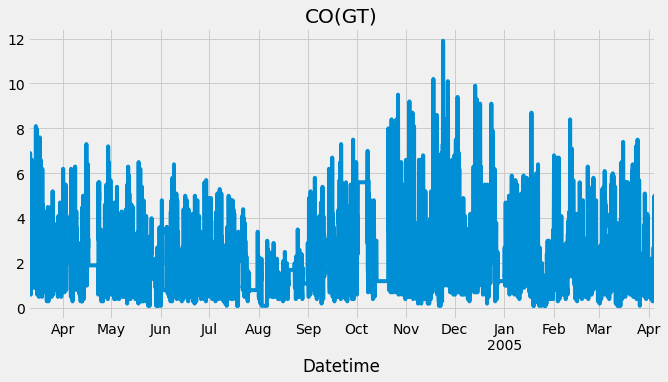

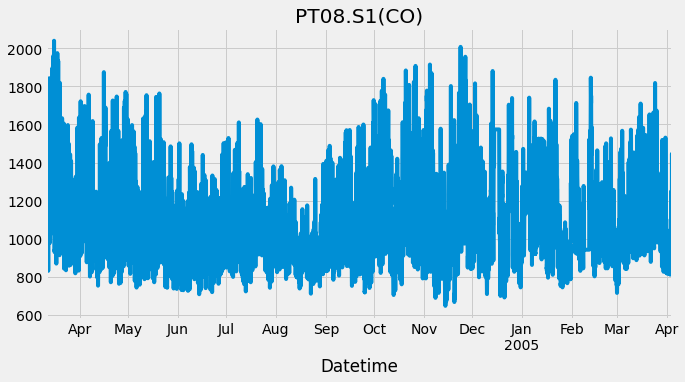

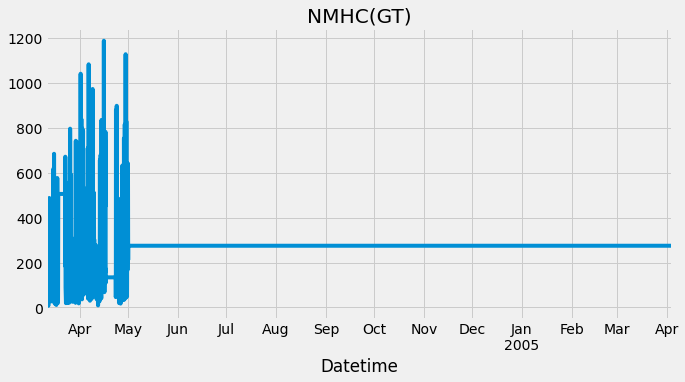

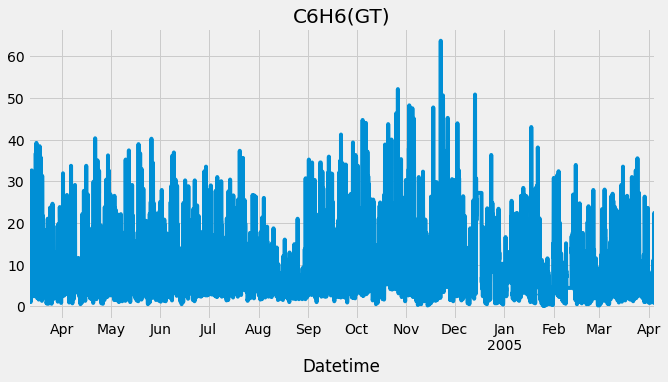

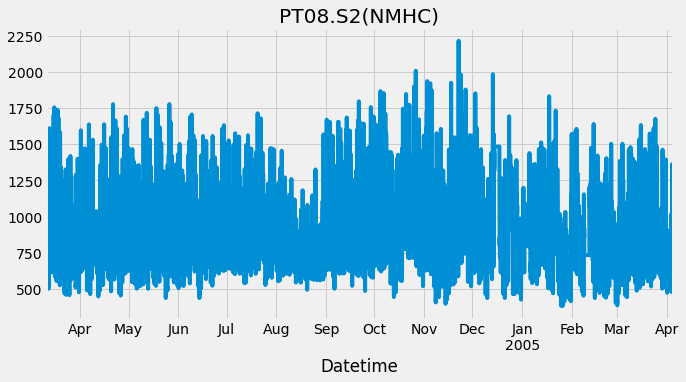

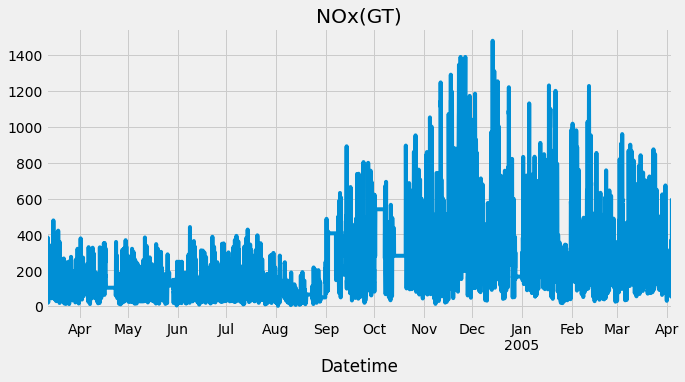

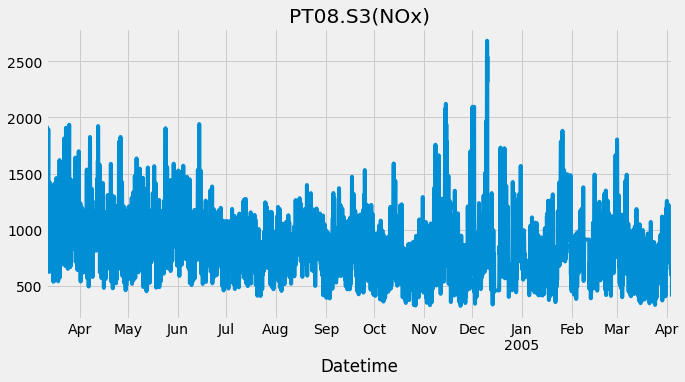

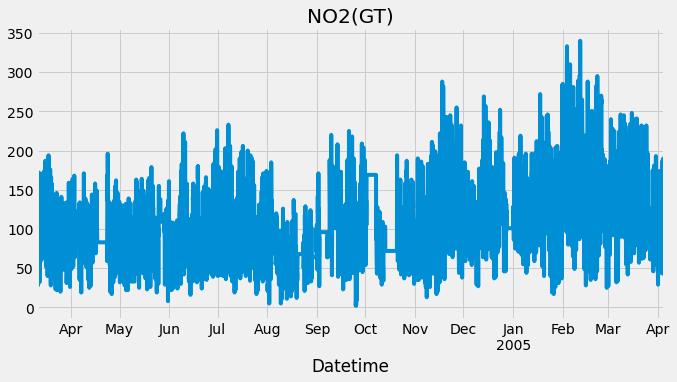

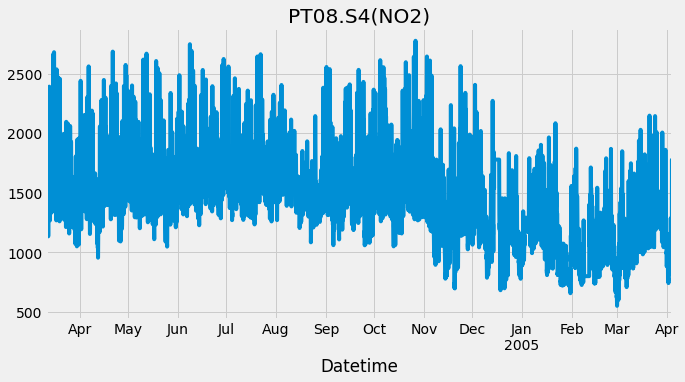

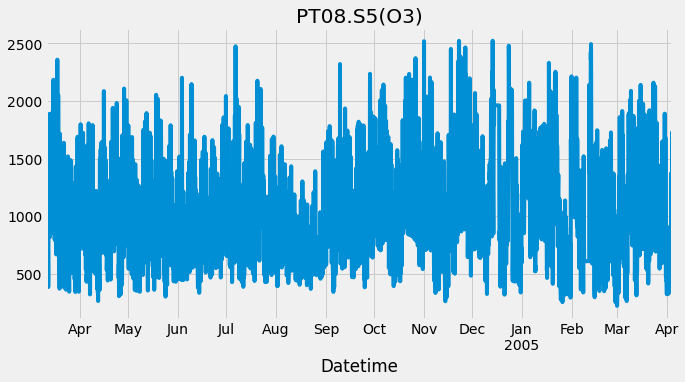

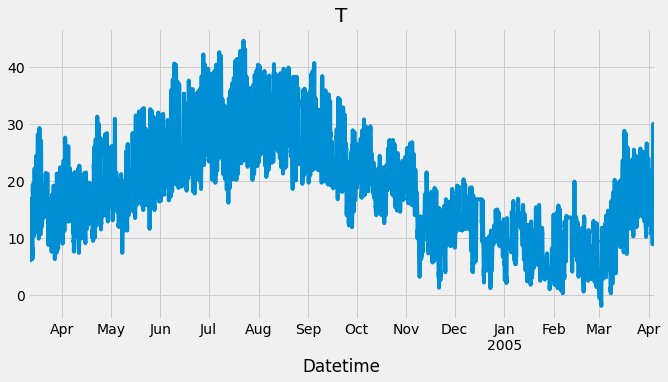

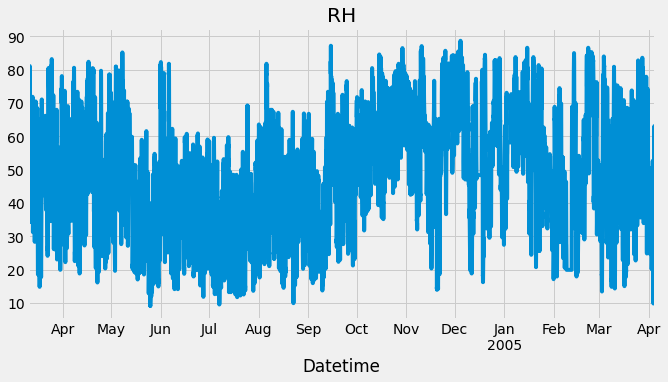

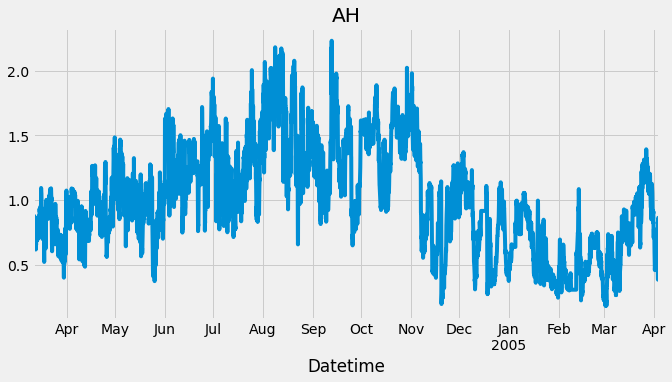

In [45]:
# visualization
for col in df.columns:
  fig, ax = plt.subplots(figsize=(10, 5))
  df[col].plot(ax=ax)
  ax.set_xlabel('Datetime')
  ax.set_title(col)
  plt.show()

## 2. Analysis

* VAR 必須要使用 stationary 的 time series
* 用 Johansen’s test 來檢查 stationary
  * coint_johansen 只支援 12 個變數，但是我的 datafram 有 13 個欄位，所以必須要捨棄其中一個欄位才能做 test
    * 隨便丟掉一個欄位來檢查 stationary
    * 可以多做幾次，每次丟掉不同的欄位來檢查 eigenvalues
    * eigenvalues < 1 才是 stationary 的

In [46]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
johan_test_temp = df.drop(['CO(GT)'], axis=1)
coint_johansen(johan_test_temp, -1, 1).eig

array([1.75510896e-01, 1.52389933e-01, 1.15120416e-01, 1.04126281e-01,
       9.29485509e-02, 6.89397159e-02, 5.77070988e-02, 3.43554214e-02,
       3.05980659e-02, 1.18697142e-02, 2.46766099e-03, 7.09584856e-05])

* 這裡發現 eigenvalue 都是小於 1 的，所以表示這個 multivariate time series 是 stationary 的
* 用 Dicky-Fuller test 來檢查每一個欄位的 stationarity

In [47]:
def ADF_Stationarity_Test(time_series):
    from statsmodels.tsa.stattools import adfuller # Use augmented dickey-fuller test to check stationality

    #Dickey-Fuller test:
    adf_test = adfuller(time_series, autolag='AIC') # AIC: Akaike information criterion (AIC), the smaller AIC the better model
    index = [
      'Test statistics (ADF)',
      'p-value',
      'Number of lags used',
      'Number of observations used'
    ]
    adf_results = pd.Series(adf_test[:4], index=index)

    #Add Critical Values
    for k, v in adf_test[4].items():
        adf_results[f'Critical value ({k})'] = v
  
    print('Results of  Augmented Dickey-Fuller Test:')
    print('-' * 50)
    print(adf_results)

    if adf_results[1] < 0.05:
        print('Because p < 0.05, we reject the null hypothesis')
        print('--> The time series is stationary.')
    else:
        print('-->The time series is not stationary')
    
    print('\n')

In [48]:
for col in df.columns:
  ADF_Stationarity_Test(df[col].values)

Results of  Augmented Dickey-Fuller Test:
--------------------------------------------------
Test statistics (ADF)         -9.423843e+00
p-value                        5.412775e-16
Number of lags used            3.700000e+01
Number of observations used    9.319000e+03
Critical value (1%)           -3.431052e+00
Critical value (5%)           -2.861850e+00
Critical value (10%)          -2.566935e+00
dtype: float64
Because p < 0.05, we reject the null hypothesis
--> The time series is stationary.


Results of  Augmented Dickey-Fuller Test:
--------------------------------------------------
Test statistics (ADF)         -9.875915e+00
p-value                        3.883044e-17
Number of lags used            3.700000e+01
Number of observations used    9.319000e+03
Critical value (1%)           -3.431052e+00
Critical value (5%)           -2.861850e+00
Critical value (10%)          -2.566935e+00
dtype: float64
Because p < 0.05, we reject the null hypothesis
--> The time series is stationary.


## 3. Forecast

In [49]:
# train test split
df_train = df[: int(0.8 * len(df))]
df_test = df[int(0.8 * len(df)): ]

print(int(0.8 * len(df)))

display(df_train.head())
display(df_test.head())

print(len(df_train))
print(len(df_test))
print(len(df_train) + len(df_test))

7485


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2005-01-16 15:00:00,0.7,833.0,275.0,2.0,584.0,107.0,1144.0,80.0,821.0,463.0,11.3,32.5,0.4334
2005-01-16 16:00:00,1.1,877.0,275.0,2.8,642.0,176.0,1037.0,112.0,859.0,565.0,11.0,33.0,0.4331
2005-01-16 17:00:00,1.1,892.0,275.0,3.3,668.0,180.0,1017.0,121.0,872.0,632.0,10.3,35.0,0.4377
2005-01-16 18:00:00,1.2,899.0,275.0,3.4,674.0,212.0,1002.0,132.0,893.0,691.0,8.4,40.9,0.4542
2005-01-16 19:00:00,2.0,1008.0,275.0,7.1,861.0,331.0,839.0,160.0,977.0,943.0,8.3,38.5,0.4228


7485
1872
9357


In [ ]:
# fit VAR model
from statsmodels.tsa.vector_ar.var_model import VAR
model = VAR(endog=df_train)
model_fitted = model.fit()

print(len(model_fitted.y))
print(model_fitted.y) # 用 df_train 做 fitting 得到的數值

# forecast
predictions = model_fitted.forecast(model_fitted.y, steps=len(df_test))
print(len(predictions))
print(predictions)

7485
[[2.600e+00 1.360e+03 1.500e+02 ... 1.360e+01 4.890e+01 7.578e-01]
 [2.000e+00 1.292e+03 1.120e+02 ... 1.330e+01 4.770e+01 7.255e-01]
 [2.200e+00 1.402e+03 8.800e+01 ... 1.190e+01 5.400e+01 7.502e-01]
 ...
 [8.000e-01 8.310e+02 2.750e+02 ... 1.110e+01 3.340e+01 4.401e-01]
 [1.000e+00 8.660e+02 2.750e+02 ... 1.190e+01 3.080e+01 4.285e-01]
 [8.000e-01 8.190e+02 2.750e+02 ... 1.140e+01 3.200e+01 4.310e-01]]
1872
[[8.87831181e-01 8.41930040e+02 2.71627237e+02 ... 1.05475985e+01
  3.49086438e+01 4.37327493e-01]
 [9.91857261e-01 8.66300135e+02 2.69296720e+02 ... 9.82637273e+00
  3.74495946e+01 4.42716879e-01]
 [1.10418099e+00 8.90877509e+02 2.67701932e+02 ... 9.21409050e+00
  3.96788583e+01 4.47482162e-01]
 ...
 [2.13382383e+00 1.10697508e+03 2.69410699e+02 ... 2.01841814e+01
  4.89013982e+01 1.11131826e+00]
 [2.13382382e+00 1.10697508e+03 2.69410699e+02 ... 2.01841816e+01
  4.89013980e+01 1.11131827e+00]
 [2.13382381e+00 1.10697507e+03 2.69410699e+02 ... 2.01841819e+01
  4.89013978e+01

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


* 因為 forecast 的結果是 numpy array，把它改成 dataframe

In [ ]:
df_train_forecast = pd.DataFrame(model_fitted.y, columns=df_train.columns, index=df_train.index)
df_train_forecast.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/wrapper.py:35: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [ ]:
df_train_forecast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7485 entries, 2004-03-10 18:00:00 to 2005-01-16 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         7485 non-null   float64
 1   PT08.S1(CO)    7485 non-null   float64
 2   NMHC(GT)       7485 non-null   float64
 3   C6H6(GT)       7485 non-null   float64
 4   PT08.S2(NMHC)  7485 non-null   float64
 5   NOx(GT)        7485 non-null   float64
 6   PT08.S3(NOx)   7485 non-null   float64
 7   NO2(GT)        7485 non-null   float64
 8   PT08.S4(NO2)   7485 non-null   float64
 9   PT08.S5(O3)    7485 non-null   float64
 10  T              7485 non-null   float64
 11  RH             7485 non-null   float64
 12  AH             7485 non-null   float64
dtypes: float64(13)
memory usage: 818.7 KB


In [ ]:
df_test_forecast = pd.DataFrame(predictions, columns=df_test.columns, index=df_test.index)
df_test_forecast.head()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Date_Time,,,,,,,,,,,,,
2005-01-16 15:00:00,0.887831,841.930040,271.627237,1.982425,595.810006,136.652961,1119.785840,87.880940,829.685784,545.724682,10.547598,34.908644,0.437327
2005-01-16 16:00:00,0.991857,866.300135,269.296720,2.327046,619.651929,157.767278,1098.690737,90.574363,856.150818,598.061035,9.826373,37.449595,0.442717
2005-01-16 17:00:00,1.104181,890.877509,267.701932,2.823187,645.301670,177.409556,1078.877607,93.129588,885.360153,648.593798,9.214091,39.678858,0.447482
2005-01-16 18:00:00,1.219169,914.856579,266.614149,3.396825,671.288989,195.619763,1060.434050,95.567038,915.323932,696.956399,8.693913,41.640506,0.451830
2005-01-16 19:00:00,1.332886,937.732765,265.865337,3.999277,696.669347,212.431288,1043.389748,97.891452,944.774167,742.857863,8.252727,43.370069,0.455894


In [ ]:
df_test_forecast.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1872 entries, 2005-01-16 15:00:00 to 2005-04-04 14:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         1872 non-null   float64
 1   PT08.S1(CO)    1872 non-null   float64
 2   NMHC(GT)       1872 non-null   float64
 3   C6H6(GT)       1872 non-null   float64
 4   PT08.S2(NMHC)  1872 non-null   float64
 5   NOx(GT)        1872 non-null   float64
 6   PT08.S3(NOx)   1872 non-null   float64
 7   NO2(GT)        1872 non-null   float64
 8   PT08.S4(NO2)   1872 non-null   float64
 9   PT08.S5(O3)    1872 non-null   float64
 10  T              1872 non-null   float64
 11  RH             1872 non-null   float64
 12  AH             1872 non-null   float64
dtypes: float64(13)
memory usage: 204.8 KB


* 比較 RMSE 看看預測的結果的好壞

In [ ]:
from sklearn.metrics import mean_squared_error
for col in df_test.columns:
  y_true = df_test[col].values
  y_pred = df_test_forecast[col].values
  rmse = mean_squared_error(y_true, y_pred, squared=False) # squared=True 就是用 MSE, squared=False 就是用 RMSE
  print(f'RMSE of {col} = {rmse}')

RMSE of CO(GT) = 1.408688883687256
RMSE of PT08.S1(CO) = 205.89558284021305
RMSE of NMHC(GT) = 6.67354871134285
RMSE of C6H6(GT) = 7.130087248705714
RMSE of PT08.S2(NMHC) = 277.84844376800464
RMSE of NOx(GT) = 214.7832234091224
RMSE of PT08.S3(NOx) = 244.9576966193527
RMSE of NO2(GT) = 66.69695211710588
RMSE of PT08.S4(NO2) = 490.08388934110286
RMSE of PT08.S5(O3) = 446.51541648881795
RMSE of T = 10.72132579560568
RMSE of RH = 17.111676248172948
RMSE of AH = 0.5216247245187544


* 畫圖比較結果

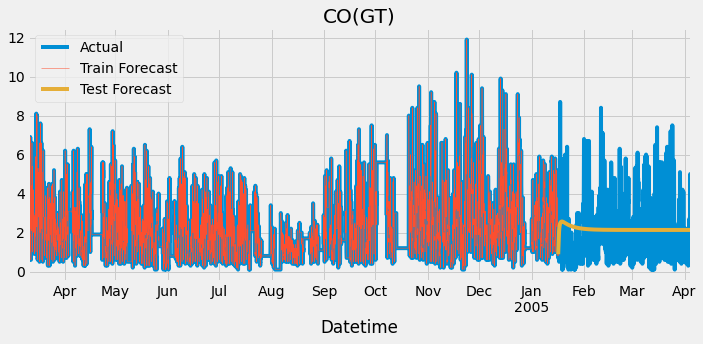

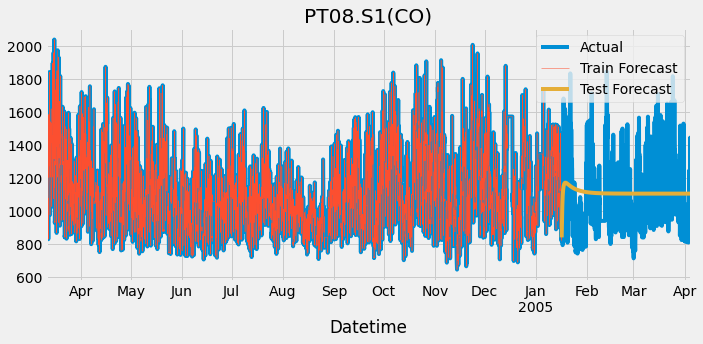

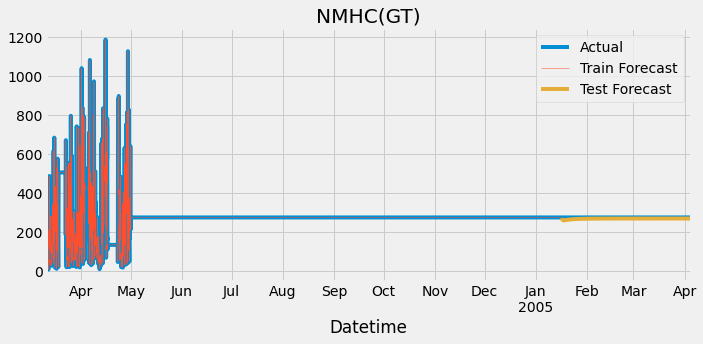

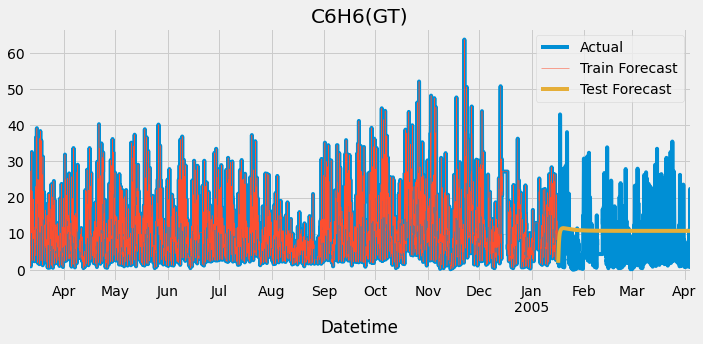

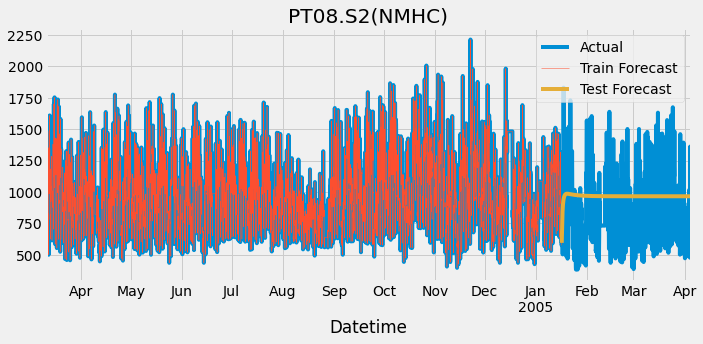

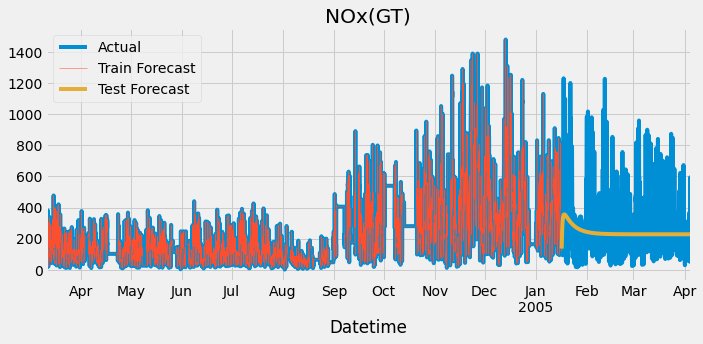

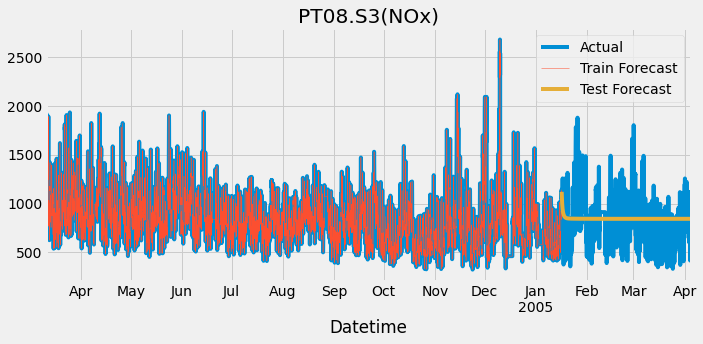

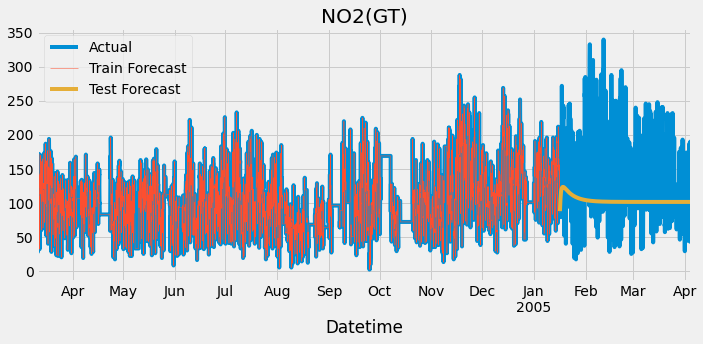

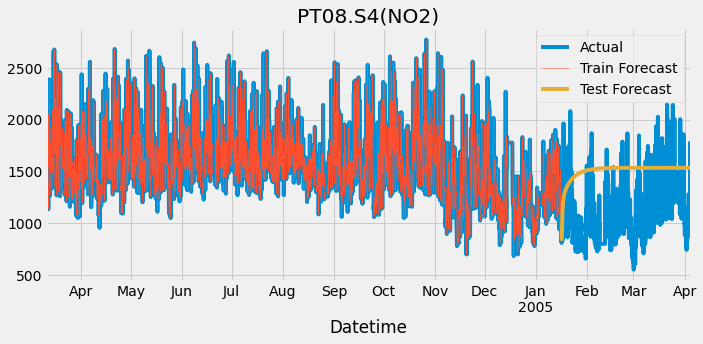

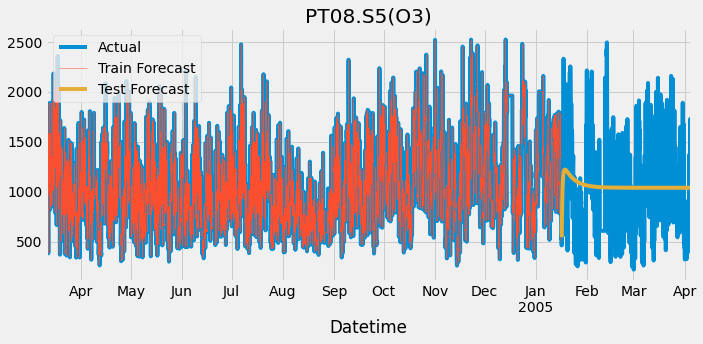

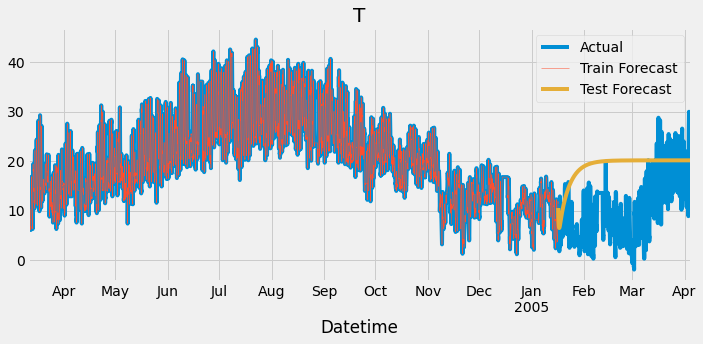

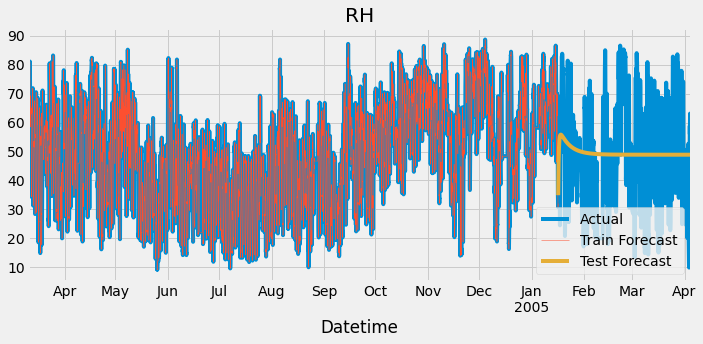

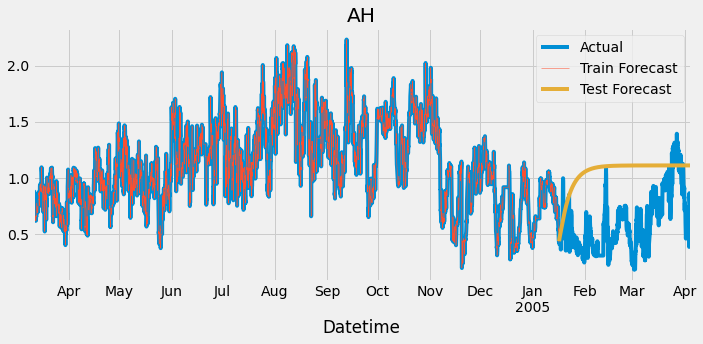

In [ ]:
for col in df.columns:
  fig, ax = plt.subplots(figsize=(10, 5))
  df[col].plot(ax=ax, label='Actual')
  df_train_forecast[col].plot(ax=ax, label='Train Forecast', linewidth=0.5)
  df_test_forecast[col].plot(ax=ax, label='Test Forecast')
  ax.set_xlabel('Datetime')
  ax.set_title(col)
  plt.legend()
  plt.tight_layout()
  plt.show()

* Training 的結果很好，但是 testing 的結果不太好，我想這原因是因為這邊採用的是 forecast all values at onces，如果換作 one-step ahead forecast 應該會比較好